# Homework 3: CIFAR-10 Dataset
## Course : Real-Time Machine Learning 5106
### Name : Lasya Vadlamudi
### Student ID : 801318796
### Github Link : https://github.com/LasyaVadlamudi/RTML


In [1]:
!pip install d2l==1.0.0-beta0

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch

from torch import nn
from torchvision import datasets,transforms
from d2l import torch as d2l

!pip install ptflops
import ptflops
from ptflops import get_model_complexity_info

from torch.utils.data import DataLoader, random_split, Subset

from torch.nn import functional as F
!pip install torchmetrics
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                      transforms.Resize(64),
                                        transforms.Normalize((0.29), (0.32)),
])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                     transforms.Resize(64),
                                        transforms.Normalize((0.29), (0.32)),
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


train_cifar, valid_cifar = random_split(cifar_trainset, [0.8, 0.2])
trainLoader = DataLoader(train_cifar, batch_size=256, shuffle=True, num_workers=1)
validateLoader = DataLoader(valid_cifar, batch_size=256, shuffle=True, num_workers=1)
testLoader = DataLoader(cifar_testset, batch_size=256, shuffle=True, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Train_Model: # A class to train and save the developed model and the metrics

    
    def __init__(self, model, loss, optimizer, accuracy, model_type, device, classes=0):
        
        self.device = device
        self.model = model.to(device) ## Setting the model on GPU
        self.Loss_Function = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        self.model_type = model_type
        self.classNum = classes
        
        # A dictionary to append or store the results
        self.Metrics = {"Training_Loss":[],"Training_Accuracy":[], "Validation_Loss":[], "Validation_Accuracy":[],"Test_Accuracy":0}  
        self.ConfMatrix = None
    
    # Function to train the model
    def model_run(self, l_data,run_type):
        
        if run_type == 'train':
          self.model.train() 
          
          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy
          
          loss_sum = 0
          acc = 0
          
          # Iterates over the data
          for data, labels in tqdm(l_data):
              
              # transform data into one-hot vectors
              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)
              
              predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)
              
              
              self.optimizer.zero_grad()
              loss_value.backward()
              self.optimizer.step()
              
              
              # Set the predictions and labels back into integers for accuracy calculation
              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])
              
              ##### Calculate Loss and accuracy
              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)
          
          self.Metrics["Training_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Training_Accuracy"].append(acc / len(l_data))
          
        
        elif run_type == 'eval':
          self.model.eval()
          
          if self.model_type == "Classification":
              MCA = self.accuracy(self.classNum)
          else:
              MCA = self.accuracy
              
          loss_sum = 0
          acc = 0
          
          for data, labels in l_data:
              
              data = data.to(self.device)
              if self.model_type == "Classification":
                  labels = torch.eye(10)[labels]
              else:
                  labels = labels.reshape(-1, 1)
              labels = labels.to(self.device)
              
              with torch.no_grad():
                  predictions = self.model(data)
              loss_value = self.Loss_Function(predictions, labels)
              
              if self.model_type == "Classification":
                  predictions = torch.Tensor([torch.argmax(i).item() for i in predictions])
                  labels = torch.Tensor([torch.argmax(i).item() for i in labels])
              
              loss_sum += loss_value.item()
              if self.model_type == "Classification":
                  acc += MCA(predictions, labels)
              
          self.Metrics["Validation_Loss"].append(loss_sum / len(l_data))
          if self.model_type == "Classification":
              self.Metrics["Validation_Accuracy"].append(acc / len(l_data))
          
    
    def fit(self, t_data, v_data, EPOCHS):
        
        
        for i in range(EPOCHS):
            
            self.model_run(v_data,'eval')
            self.model_run(t_data,'train')
                
            print("Current Epoch:", i+1)
            print("Training_Loss:", self.Metrics["Training_Loss"][-1], " | Validation_Loss:", self.Metrics["Validation_Loss"][-1])
            if self.model_type == "Classification":
                print("Training_Accuracy:", self.Metrics["Training_Accuracy"][-1].item(), " | Validation_Accuracy:", self.Metrics["Validation_Accuracy"][-1].item())
            
    
    def Test_Model(self, testLoader):
        
        self.model.eval()
        
        if self.model_type == "Classification":
            confusion = ConfusionMatrix(task="multiclass", num_classes=self.classNum)
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy
        
        predMax = torch.empty(0)
        labelMax = torch.empty(0)
    
        for data, labels in testLoader:

            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)

            with torch.no_grad():
                pred = self.model(data)

            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])

            predMax = torch.cat((predMax, pred))
            labelMax = torch.cat((labelMax, labels))
        
        if self.model_type == "Classification":
            self.ConfMatrix = confusion(predMax, labelMax)
            self.Metrics["Test_Accuracy"] = MCA(predMax, labelMax).item()
        
    
    

In [4]:
def init_cnn(module):
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)


In [5]:
#@d2l.add_to_class(d2l.Trainer)  
def __init__(self, max_epochs, num_gpus=1, gradient_clip_val=0):
        self.save_hyperparameters()
        self.train_loss = []
        self.train_acc = []
        self.valid_loss = []
        self.valid_acc = []

        assert num_gpus == 1,'No GPU support yet'
        

In [6]:
@d2l.add_to_class(d2l.Classifier)  
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)



In [7]:
#@d2l.add_to_class(d2l.Module)  
def training_step(self, batch):
  l = self.loss(self(*batch[:-1]), batch[-1])
  self.plot('loss', l, train=True)
  self.train_loss.append(l)
  return l

#@d2l.add_to_class(d2l.Module)  
def validation_step(self, batch):
  l = self.loss(self(*batch[:-1]), batch[-1])
  self.valid_loss.append(l)
  self.plot('loss', l, train=False)

In [8]:
#@d2l.add_to_class(d2l.Module)  
def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
            metric_type = 'train'
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
            metric_type = 'val'
        self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
        
        if not train and self.trainer.epoch % 1 == 0:
          train_loss = self.trainer.train_loss[-1]
          #train_acc = self.trainer.train_acc[-1]
          val_loss = self.trainer.valid_loss[-1]
          #val_acc = self.trainer.valid_acc[-1]
          print(f"Epoch [{self.trainer.epoch+1}/{self.trainer.epochs}]: "
                f"train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f}, ")
               # f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}")

In [9]:
#@d2l.add_to_class(d2l.Trainer)  
def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
            self.evaluate()

In [10]:
device_to_use = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Problem 1:  
Part a) BaseLine VGG Model

In [11]:
def vgg_block(num_convs, out_channels, stride):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())

    layers.append(nn.MaxPool2d(kernel_size=2, stride=stride))

    return nn.Sequential(*layers)

In [12]:
class VGG(nn.Module):
    def __init__(self, arch, num_class=10):
        super(VGG, self).__init__()
        conv_blks = []
        
        for num_convs, out_channels, stride in arch:
            conv_blks.append(vgg_block(num_convs, out_channels, stride))
            
        self.net = nn.Sequential(
            *conv_blks, 
            
            nn.Flatten(),
            nn.LazyLinear(4096), 
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.LazyLinear(num_class),
        )
        
    def forward(self, x):
        return self.net(x)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
100%|██████████| 157/157 [00:34<00:00,  4.57it/s]

Current Epoch: 1
Training_Loss: 1.7130343610314047  | Validation_Loss: 2.3025812327861788
Training_Accuracy: 0.36791566014289856  | Validation_Accuracy: 0.09999995678663254



100%|██████████| 157/157 [00:33<00:00,  4.63it/s]

Current Epoch: 2
Training_Loss: 1.377897314964586  | Validation_Loss: 1.5861882716417313
Training_Accuracy: 0.5023663640022278  | Validation_Accuracy: 0.4109349846839905



100%|██████████| 157/157 [00:34<00:00,  4.54it/s]

Current Epoch: 3
Training_Loss: 1.1583374655170806  | Validation_Loss: 1.6435048699378967
Training_Accuracy: 0.5900500416755676  | Validation_Accuracy: 0.4360102713108063



100%|██████████| 157/157 [00:34<00:00,  4.54it/s]

Current Epoch: 4
Training_Loss: 0.9467963933185407  | Validation_Loss: 1.147178004682064
Training_Accuracy: 0.6744588613510132  | Validation_Accuracy: 0.6158866882324219



100%|██████████| 157/157 [00:34<00:00,  4.58it/s]

Current Epoch: 5
Training_Loss: 0.7605591739059254  | Validation_Loss: 0.9711459562182426
Training_Accuracy: 0.7436625957489014  | Validation_Accuracy: 0.6689659357070923



100%|██████████| 157/157 [00:34<00:00,  4.60it/s]

Current Epoch: 6
Training_Loss: 0.6257060857335474  | Validation_Loss: 1.066545444726944
Training_Accuracy: 0.7950770854949951  | Validation_Accuracy: 0.6474282145500183



100%|██████████| 157/157 [00:34<00:00,  4.58it/s]

Current Epoch: 7
Training_Loss: 0.5244184563494032  | Validation_Loss: 0.815202233940363
Training_Accuracy: 0.8279990553855896  | Validation_Accuracy: 0.7238074541091919



100%|██████████| 157/157 [00:35<00:00,  4.47it/s]

Current Epoch: 8
Training_Loss: 0.4410933559867227  | Validation_Loss: 0.7510030388832092
Training_Accuracy: 0.8539358973503113  | Validation_Accuracy: 0.7489427328109741



100%|██████████| 157/157 [00:34<00:00,  4.58it/s]

Current Epoch: 9
Training_Loss: 0.3612378294680529  | Validation_Loss: 0.963985151052475
Training_Accuracy: 0.8810418248176575  | Validation_Accuracy: 0.7214068174362183



100%|██████████| 157/157 [00:34<00:00,  4.58it/s]

Current Epoch: 10
Training_Loss: 0.31265028684761875  | Validation_Loss: 0.9495124578475952
Training_Accuracy: 0.8976224660873413  | Validation_Accuracy: 0.7243995070457458


Time Taken to Train: 0:06:51.667923
VGG Baseline Model Train Accuracy: 0.8976224660873413
VGG Baseline Model Test Accuracy: 0.7573999762535095
Macs:639.21 MMac | Params:34.44 M


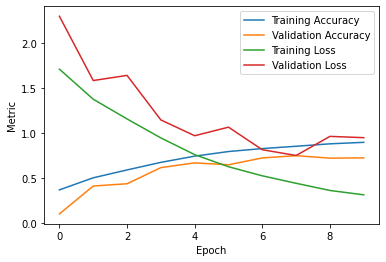

In [13]:
arch = [(1, 64, 2), (1, 128, 2), (2, 256, 2), (2, 512, 2), (2, 512, 2)]
vgg_baseline_arch = VGG(arch)


VGG_baseline_model = Train_Model(vgg_baseline_arch, nn.CrossEntropyLoss(), torch.optim.SGD(vgg_baseline_arch.parameters(), lr=0.001*120, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
VGG_baseline_model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

VGG_baseline_model.Test_Model(testLoader)

macs, params = get_model_complexity_info(VGG_baseline_model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("VGG Baseline Model Train Accuracy:", VGG_baseline_model.Metrics["Training_Accuracy"][-1].item())
print("VGG Baseline Model Test Accuracy:", VGG_baseline_model.Metrics["Test_Accuracy"])
    
VGG_baseline_model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(VGG_baseline_model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(VGG_baseline_model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(VGG_baseline_model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(VGG_baseline_model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

Part b) 


Build VGG-16 Model

100%|██████████| 157/157 [00:59<00:00,  2.64it/s]

Current Epoch: 1
Training_Loss: 1.98881136080262  | Validation_Loss: 2.3026345551013945
Training_Accuracy: 0.22571179270744324  | Validation_Accuracy: 0.09749995917081833



100%|██████████| 157/157 [00:59<00:00,  2.65it/s]

Current Epoch: 2
Training_Loss: 1.633979301543752  | Validation_Loss: 1.8679631322622299
Training_Accuracy: 0.37843966484069824  | Validation_Accuracy: 0.2675599455833435



100%|██████████| 157/157 [01:00<00:00,  2.60it/s]


Current Epoch: 3
Training_Loss: 1.3199783092851092  | Validation_Loss: 1.762951534986496
Training_Accuracy: 0.5187881588935852  | Validation_Accuracy: 0.35180380940437317


100%|██████████| 157/157 [01:01<00:00,  2.57it/s]

Current Epoch: 4
Training_Loss: 1.046694423742355  | Validation_Loss: 1.306266376376152
Training_Accuracy: 0.6346768140792847  | Validation_Accuracy: 0.5213571190834045



100%|██████████| 157/157 [00:59<00:00,  2.65it/s]

Current Epoch: 5
Training_Loss: 0.8482123286860763  | Validation_Loss: 1.321761965751648
Training_Accuracy: 0.7124564051628113  | Validation_Accuracy: 0.5575709342956543



100%|██████████| 157/157 [00:59<00:00,  2.64it/s]

Current Epoch: 6
Training_Loss: 0.6892725073607864  | Validation_Loss: 1.3756370753049851
Training_Accuracy: 0.7713412642478943  | Validation_Accuracy: 0.5888323187828064



100%|██████████| 157/157 [00:58<00:00,  2.66it/s]

Current Epoch: 7
Training_Loss: 0.5739127407028417  | Validation_Loss: 0.9215824797749519
Training_Accuracy: 0.810810387134552  | Validation_Accuracy: 0.6885113716125488



100%|██████████| 157/157 [00:59<00:00,  2.65it/s]

Current Epoch: 8
Training_Loss: 0.493890069472562  | Validation_Loss: 0.746697661280632
Training_Accuracy: 0.8370230197906494  | Validation_Accuracy: 0.7478337287902832



100%|██████████| 157/157 [00:59<00:00,  2.64it/s]

Current Epoch: 9
Training_Loss: 0.4297104830954485  | Validation_Loss: 0.6387138053774833
Training_Accuracy: 0.861245334148407  | Validation_Accuracy: 0.7910525798797607



100%|██████████| 157/157 [00:59<00:00,  2.64it/s]

Current Epoch: 10
Training_Loss: 0.3660578178182529  | Validation_Loss: 0.7699073776602745
Training_Accuracy: 0.8794954419136047  | Validation_Accuracy: 0.7586781978607178


Time Taken to Train: 0:10:57.468966
VGG-16 Model Train Accuracy: 0.8794954419136047
VGG-16 Model Test Accuracy: 0.7908999919891357
Macs:1.28 GMac | Params:39.94 M


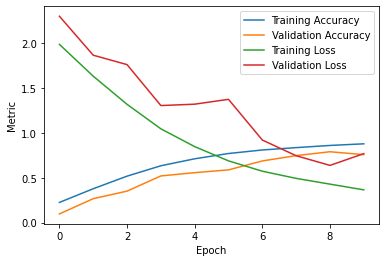

In [14]:
arch_16 = [(2, 64, 2), (2, 128, 2), (3, 256, 2), (3, 512, 2), (3, 512, 2)]
vgg_16_arch = VGG(arch_16)


VGG_16_model = Train_Model(vgg_16_arch, nn.CrossEntropyLoss(), torch.optim.SGD(vgg_16_arch.parameters(), lr=0.001*90, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
VGG_16_model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

VGG_16_model.Test_Model(testLoader)

macs, params = get_model_complexity_info(VGG_16_model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("VGG-16 Model Train Accuracy:", VGG_16_model.Metrics["Training_Accuracy"][-1].item())
print("VGG-16 Model Test Accuracy:", VGG_16_model.Metrics["Test_Accuracy"])

    
VGG_16_model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(VGG_16_model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(VGG_16_model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(VGG_16_model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(VGG_16_model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Results --  Model Comparison
#### VGG Baseline Model

---



Time Taken to Train: 0:06:51.667923  
VGG Baseline Model Train Accuracy: 0.8976224660873413  
VGG Baseline Model Test Accuracy: 0.7573999762535095  
Macs:639.21 MMac | Params:34.44 M

#### VGG-16

---


    
Time Taken to Train: 0:10:57.468966  
VGG-16 Model Train Accuracy: 0.8794954419136047  
VGG-16 Model Test Accuracy: 0.7908999919891357  
Macs:1.28 GMac | Params:39.94 M

Problem 2:

part a) Baseline GoogleNet

In [15]:
class Inception_block(nn.Module):
  def __init__(self, c1, c2, c3, c4, use_bn=False):
      super(Inception_block, self).__init__()
      
      self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
      
      self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
      self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3,padding=1)

      self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
      self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5,padding=2)

      self.b4_1 = nn.MaxPool2d(padding=1,stride=1, kernel_size=3)
      self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

      
      

  def forward(self, x):
      b1 = F.relu(self.b1_1(x))
      b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
      b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
      b4 = F.relu(self.b4_2(self.b4_1(x)))
      return torch.cat([b1,b2,b3,b4], 1)

In [16]:
class GoogleNet(nn.Module):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

  def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))



  def b3(self):
    return nn.Sequential(Inception_block(64, (96, 128), (16, 32), 32),
                        Inception_block(128, (128, 192), (32, 96), 64),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
  def b4(self):
    return nn.Sequential(Inception_block(192, (96, 208), (16, 48), 64),
                        Inception_block(160, (112, 224), (24, 64), 64),
                        Inception_block(128, (128, 256), (24, 64), 64),
                        Inception_block(112, (144, 288), (32, 64), 64),
                        Inception_block(256, (160, 320), (32, 128), 128),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
  def b5(self):
    return nn.Sequential(Inception_block(256, (160, 320), (32, 128), 128),
                  Inception_block(384, (192, 384), (48, 128), 128),
                  nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
    
  def __init__(self, use_bn=False):
      super(GoogleNet, self).__init__()
      self.use_bn = use_bn
      self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                            self.b5(), nn.LazyLinear(10))
      
  
      
  
  def forward(self, x):
      return self.net(x)
      

100%|██████████| 157/157 [00:37<00:00,  4.19it/s]

Current Epoch: 1
Training_Loss: 2.303522459260977  | Validation_Loss: 2.303099584579468
Training_Accuracy: 0.10063952952623367  | Validation_Accuracy: 0.09999995678663254



100%|██████████| 157/157 [00:39<00:00,  3.96it/s]

Current Epoch: 2
Training_Loss: 2.2633963010873006  | Validation_Loss: 2.3028821885585784
Training_Accuracy: 0.12408294528722763  | Validation_Accuracy: 0.09999995678663254



100%|██████████| 157/157 [00:38<00:00,  4.06it/s]

Current Epoch: 3
Training_Loss: 2.133713237798897  | Validation_Loss: 2.093826252222061
Training_Accuracy: 0.1694355309009552  | Validation_Accuracy: 0.19918307662010193



100%|██████████| 157/157 [00:38<00:00,  4.05it/s]

Current Epoch: 4
Training_Loss: 2.061371665851326  | Validation_Loss: 1.9858199864625932
Training_Accuracy: 0.1934715360403061  | Validation_Accuracy: 0.2232588231563568



100%|██████████| 157/157 [00:39<00:00,  3.97it/s]

Current Epoch: 5
Training_Loss: 1.9910011580035945  | Validation_Loss: 1.8917727023363113
Training_Accuracy: 0.22473792731761932  | Validation_Accuracy: 0.271103173494339



100%|██████████| 157/157 [00:40<00:00,  3.84it/s]

Current Epoch: 6
Training_Loss: 1.9396199284085802  | Validation_Loss: 1.7412960261106492
Training_Accuracy: 0.24621032178401947  | Validation_Accuracy: 0.3500802218914032



100%|██████████| 157/157 [00:38<00:00,  4.03it/s]

Current Epoch: 7
Training_Loss: 1.8831215876682548  | Validation_Loss: 1.714194867014885
Training_Accuracy: 0.2725353240966797  | Validation_Accuracy: 0.35194048285484314



100%|██████████| 157/157 [00:39<00:00,  3.96it/s]

Current Epoch: 8
Training_Loss: 1.8373695611953735  | Validation_Loss: 1.6184053659439086
Training_Accuracy: 0.2919488847255707  | Validation_Accuracy: 0.41310301423072815



100%|██████████| 157/157 [00:39<00:00,  3.97it/s]

Current Epoch: 9
Training_Loss: 1.7750520303750494  | Validation_Loss: 1.5950415849685669
Training_Accuracy: 0.31842735409736633  | Validation_Accuracy: 0.42498940229415894



100%|██████████| 157/157 [00:38<00:00,  4.06it/s]

Current Epoch: 10
Training_Loss: 1.738339441597082  | Validation_Loss: 1.4201813817024231
Training_Accuracy: 0.33688339591026306  | Validation_Accuracy: 0.4822447896003723


Time Taken to Train: 0:07:31.100964
GoogleNet Model Train Accuracy: 0.33688339591026306
GoogleNet Model Test Accuracy: 0.5223000049591064
Macs:660.48 MMac | Params:2.77 M


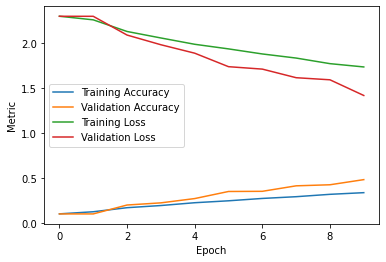

In [20]:
gNet_arch = GoogleNet()
GoogleNet_Model = Train_Model(gNet_arch, nn.CrossEntropyLoss(), torch.optim.SGD(gNet_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
GoogleNet_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

GoogleNet_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(GoogleNet_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("GoogleNet Model Train Accuracy:", GoogleNet_Model.Metrics["Training_Accuracy"][-1].item())
print("GoogleNet Model Test Accuracy:", GoogleNet_Model.Metrics["Test_Accuracy"])

    
GoogleNet_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(GoogleNet_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(GoogleNet_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(GoogleNet_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(GoogleNet_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

Part b) Add Batch Normalization

100%|██████████| 157/157 [00:41<00:00,  3.79it/s]

Current Epoch: 1
Training_Loss: 1.9080926779728786  | Validation_Loss: 2.3025783240795135
Training_Accuracy: 0.2693159878253937  | Validation_Accuracy: 0.09749995917081833



100%|██████████| 157/157 [00:41<00:00,  3.74it/s]

Current Epoch: 2
Training_Loss: 1.7020056217339388  | Validation_Loss: 1.882470005750656
Training_Accuracy: 0.36051422357559204  | Validation_Accuracy: 0.3091454803943634



100%|██████████| 157/157 [00:41<00:00,  3.80it/s]

Current Epoch: 3
Training_Loss: 1.5871015468220802  | Validation_Loss: 1.4772337824106216
Training_Accuracy: 0.4068325161933899  | Validation_Accuracy: 0.454537570476532



100%|██████████| 157/157 [00:41<00:00,  3.76it/s]

Current Epoch: 4
Training_Loss: 1.483576867990433  | Validation_Loss: 1.3209970772266388
Training_Accuracy: 0.44752034544944763  | Validation_Accuracy: 0.5377708077430725



100%|██████████| 157/157 [00:44<00:00,  3.57it/s]

Current Epoch: 5
Training_Loss: 1.4314093346808368  | Validation_Loss: 1.2319439440965652
Training_Accuracy: 0.4655749201774597  | Validation_Accuracy: 0.5594832897186279



100%|██████████| 157/157 [00:42<00:00,  3.69it/s]

Current Epoch: 6
Training_Loss: 1.3696170422681577  | Validation_Loss: 1.0322759374976158
Training_Accuracy: 0.4874570369720459  | Validation_Accuracy: 0.6587958931922913



100%|██████████| 157/157 [00:41<00:00,  3.75it/s]

Current Epoch: 7
Training_Loss: 1.3163370706473188  | Validation_Loss: 0.9954254195094109
Training_Accuracy: 0.5071665644645691  | Validation_Accuracy: 0.6577142477035522



100%|██████████| 157/157 [00:41<00:00,  3.74it/s]

Current Epoch: 8
Training_Loss: 1.2880526614037289  | Validation_Loss: 1.1201131463050842
Training_Accuracy: 0.5168569684028625  | Validation_Accuracy: 0.6117154359817505



100%|██████████| 157/157 [00:42<00:00,  3.71it/s]

Current Epoch: 9
Training_Loss: 1.2664368630974157  | Validation_Loss: 0.9425307244062424
Training_Accuracy: 0.5249510407447815  | Validation_Accuracy: 0.6709490418434143



100%|██████████| 157/157 [00:41<00:00,  3.74it/s]

Current Epoch: 10
Training_Loss: 1.2334655929522909  | Validation_Loss: 0.8218594297766686
Training_Accuracy: 0.5360414981842041  | Validation_Accuracy: 0.7183423042297363


Time Taken to Train: 0:08:02.120063
GoogleNet Batch Normalization Model Train Accuracy: 0.5360414981842041
GoogleNet Batch Normalization Model Test Accuracy: 0.7067999243736267
Macs:662.13 MMac | Params:2.78 M


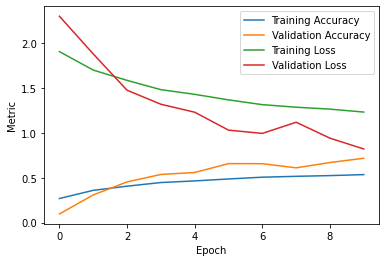

In [21]:
gNet_bn_arch = GoogleNet(use_bn=True)
GoogleNet_norm_Model = Train_Model(gNet_bn_arch, nn.CrossEntropyLoss(), torch.optim.SGD(gNet_bn_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
GoogleNet_norm_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

GoogleNet_norm_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(GoogleNet_norm_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("GoogleNet Batch Normalization Model Train Accuracy:", GoogleNet_norm_Model.Metrics["Training_Accuracy"][-1].item())
print("GoogleNet Batch Normalization Model Test Accuracy:", GoogleNet_norm_Model.Metrics["Test_Accuracy"])

    
GoogleNet_norm_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(GoogleNet_norm_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(GoogleNet_norm_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(GoogleNet_norm_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(GoogleNet_norm_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Results --  Model Comparison after adding Batch Normalization
#### GoogLeNet Baseline Model

---



Time Taken to Train: 0:07:31.100964  
GoogleNet Model Train Accuracy: 0.33688339591026306  
GoogleNet Model Test Accuracy: 0.5223000049591064  
Macs:660.48 MMac | Params:2.77 M

#### GoogLeNet Model with Batch Normalization

---


    
Time Taken to Train: 0:08:02.120063  
GoogleNet Batch Normalization Model Train Accuracy: 0.5360414981842041  
GoogleNet Batch Normalization Model Test Accuracy: 0.7067999243736267  
Macs:662.13 MMac | Params:2.78 M  

Batch Normalization helped improving the accuracy by close to 20% and has taken 30 seconds more to train.


Problem 3:  
Part a) Baseline ResNet-18

In [22]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
        

In [23]:
class ResNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def block(self, num_residuals, num_channels, first_block=False):
      blk = []
      for i in range(num_residuals):
          if i == 0 and not first_block:
              blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
          else:
              blk.append(Residual(num_channels))
      return nn.Sequential(*blk)

    def __init__(self, arch, lr=0.1, num_classes=10):
      super(ResNet, self).__init__()
      
      self.net = nn.Sequential(self.b1())
      for i, b in enumerate(arch):
          self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
      self.net.add_module('last', nn.Sequential(
          nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
          nn.LazyLinear(num_classes)))
      self.net.apply(d2l.init_cnn)

    def forward(self, x):
        return self.net(x)




100%|██████████| 157/157 [00:25<00:00,  6.15it/s]

Current Epoch: 1
Training_Loss: 1.7784921500333555  | Validation_Loss: 2.3028887689113615
Training_Accuracy: 0.36373183131217957  | Validation_Accuracy: 0.09749995917081833



100%|██████████| 157/157 [00:26<00:00,  5.90it/s]

Current Epoch: 2
Training_Loss: 1.285133929768945  | Validation_Loss: 1.607448798418045
Training_Accuracy: 0.5362505316734314  | Validation_Accuracy: 0.440591961145401



100%|██████████| 157/157 [00:25<00:00,  6.15it/s]

Current Epoch: 3
Training_Loss: 1.0478743580496235  | Validation_Loss: 1.2179712861776353
Training_Accuracy: 0.630338191986084  | Validation_Accuracy: 0.5560810565948486



100%|██████████| 157/157 [00:26<00:00,  6.04it/s]

Current Epoch: 4
Training_Loss: 0.8772715466796972  | Validation_Loss: 1.0796271607279777
Training_Accuracy: 0.693493664264679  | Validation_Accuracy: 0.6153527498245239



100%|██████████| 157/157 [00:25<00:00,  6.12it/s]

Current Epoch: 5
Training_Loss: 0.7417342742537237  | Validation_Loss: 1.0926261052489281
Training_Accuracy: 0.7411274313926697  | Validation_Accuracy: 0.6291943192481995



100%|██████████| 157/157 [00:25<00:00,  6.14it/s]

Current Epoch: 6
Training_Loss: 0.621843221271114  | Validation_Loss: 0.9080036506056786
Training_Accuracy: 0.7861961126327515  | Validation_Accuracy: 0.6864392161369324



100%|██████████| 157/157 [00:25<00:00,  6.11it/s]

Current Epoch: 7
Training_Loss: 0.49111483658954597  | Validation_Loss: 0.8679971769452095
Training_Accuracy: 0.8313446044921875  | Validation_Accuracy: 0.7054575681686401



100%|██████████| 157/157 [00:25<00:00,  6.12it/s]

Current Epoch: 8
Training_Loss: 0.3815877613178484  | Validation_Loss: 0.9176779717206955
Training_Accuracy: 0.8715055584907532  | Validation_Accuracy: 0.704586386680603



100%|██████████| 157/157 [00:25<00:00,  6.21it/s]

Current Epoch: 9
Training_Loss: 0.3009584089563151  | Validation_Loss: 0.9476412162184715
Training_Accuracy: 0.8980315327644348  | Validation_Accuracy: 0.7087833881378174



100%|██████████| 157/157 [00:26<00:00,  5.86it/s]

Current Epoch: 10
Training_Loss: 0.223610167528034  | Validation_Loss: 0.9640276059508324
Training_Accuracy: 0.9243401885032654  | Validation_Accuracy: 0.7168797254562378


Time Taken to Train: 0:05:13.292934
ResNet-18 Model Train Accuracy: 0.9243401885032654
ResNet-18 Model Test Accuracy: 0.7236999869346619
Macs:148.76 MMac | Params:11.18 M


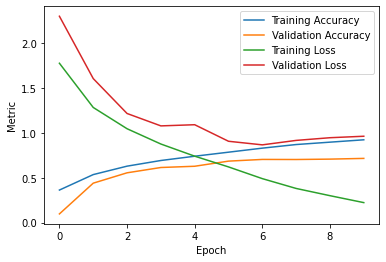

In [24]:
resnet_18_arch = ResNet(((2, 64), (2, 128), (2, 256), (2, 512)))

resnet_18_Model = Train_Model(resnet_18_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_18_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_18_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_18_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_18_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-18 Model Train Accuracy:", resnet_18_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-18 Model Test Accuracy:", resnet_18_Model.Metrics["Test_Accuracy"])

    
resnet_18_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_18_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_18_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_18_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_18_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

Part b) ResNet-26 Model

100%|██████████| 157/157 [00:25<00:00,  6.04it/s]

Current Epoch: 1
Training_Loss: 1.8332353177343963  | Validation_Loss: 2.302375066280365
Training_Accuracy: 0.3431061804294586  | Validation_Accuracy: 0.09999995678663254



100%|██████████| 157/157 [00:26<00:00,  6.03it/s]

Current Epoch: 2
Training_Loss: 1.3367187931279467  | Validation_Loss: 1.4924504339694977
Training_Accuracy: 0.5192383527755737  | Validation_Accuracy: 0.45656442642211914



100%|██████████| 157/157 [00:25<00:00,  6.09it/s]

Current Epoch: 3
Training_Loss: 1.1401197561033212  | Validation_Loss: 1.2529768615961074
Training_Accuracy: 0.5946888327598572  | Validation_Accuracy: 0.5560831427574158



100%|██████████| 157/157 [00:31<00:00,  4.93it/s]

Current Epoch: 4
Training_Loss: 0.9602623198442398  | Validation_Loss: 1.3017807751893997
Training_Accuracy: 0.6630629897117615  | Validation_Accuracy: 0.5518912076950073



100%|██████████| 157/157 [00:26<00:00,  5.95it/s]

Current Epoch: 5
Training_Loss: 0.8257238416914727  | Validation_Loss: 0.9637912437319756
Training_Accuracy: 0.7118138670921326  | Validation_Accuracy: 0.6547685861587524



100%|██████████| 157/157 [00:25<00:00,  6.04it/s]

Current Epoch: 6
Training_Loss: 0.7089845781113692  | Validation_Loss: 1.0287269219756126
Training_Accuracy: 0.7550321817398071  | Validation_Accuracy: 0.6557901501655579



100%|██████████| 157/157 [00:26<00:00,  5.94it/s]

Current Epoch: 7
Training_Loss: 0.6042578590523665  | Validation_Loss: 0.977295272052288
Training_Accuracy: 0.7936270833015442  | Validation_Accuracy: 0.6826881170272827



100%|██████████| 157/157 [00:26<00:00,  6.00it/s]

Current Epoch: 8
Training_Loss: 0.4983976629509288  | Validation_Loss: 0.8936097413301468
Training_Accuracy: 0.8290793299674988  | Validation_Accuracy: 0.705004096031189



100%|██████████| 157/157 [00:26<00:00,  6.03it/s]

Current Epoch: 9
Training_Loss: 0.40235565441429233  | Validation_Loss: 0.8762376829981804
Training_Accuracy: 0.8619043827056885  | Validation_Accuracy: 0.7191401720046997



100%|██████████| 157/157 [00:27<00:00,  5.80it/s]

Current Epoch: 10
Training_Loss: 0.32146137639595446  | Validation_Loss: 0.8827993959188462
Training_Accuracy: 0.8908166289329529  | Validation_Accuracy: 0.7342544794082642


Time Taken to Train: 0:05:24.531777
ResNet-26 Model Train Accuracy: 0.8908166289329529
ResNet-26 Model Test Accuracy: 0.7288999557495117
Macs:186.59 MMac | Params:12.66 M


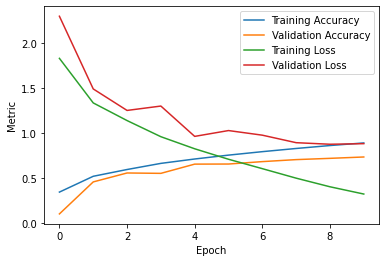

In [25]:
resnet_26_arch = ResNet(((2, 64), (3, 128), (3, 256), (2, 512)))

resnet_26_Model = Train_Model(resnet_26_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_26_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_26_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_26_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_26_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-26 Model Train Accuracy:", resnet_26_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-26 Model Test Accuracy:", resnet_26_Model.Metrics["Test_Accuracy"])

    
resnet_26_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_26_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_26_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_26_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_26_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

ResNet-32 Model

100%|██████████| 157/157 [00:29<00:00,  5.41it/s]

Current Epoch: 1
Training_Loss: 2.634732035314961  | Validation_Loss: 2.302809774875641
Training_Accuracy: 0.11624844372272491  | Validation_Accuracy: 0.10674691200256348



100%|██████████| 157/157 [00:28<00:00,  5.49it/s]

Current Epoch: 2
Training_Loss: 2.0729341013416365  | Validation_Loss: 2.2243247985839845
Training_Accuracy: 0.21823273599147797  | Validation_Accuracy: 0.14884015917778015



100%|██████████| 157/157 [00:25<00:00,  6.05it/s]

Current Epoch: 3
Training_Loss: 1.764263367956611  | Validation_Loss: 2.1008968353271484
Training_Accuracy: 0.3392455279827118  | Validation_Accuracy: 0.2050163447856903



100%|██████████| 157/157 [00:30<00:00,  5.12it/s]

Current Epoch: 4
Training_Loss: 1.5329420566558838  | Validation_Loss: 1.661171168088913
Training_Accuracy: 0.438223659992218  | Validation_Accuracy: 0.381881982088089



100%|██████████| 157/157 [00:26<00:00,  5.97it/s]

Current Epoch: 5
Training_Loss: 1.3620300475199512  | Validation_Loss: 1.4728706985712052
Training_Accuracy: 0.504921555519104  | Validation_Accuracy: 0.4607784152030945



100%|██████████| 157/157 [00:26<00:00,  5.95it/s]

Current Epoch: 6
Training_Loss: 1.2363454741277513  | Validation_Loss: 1.494406169652939
Training_Accuracy: 0.5537471175193787  | Validation_Accuracy: 0.46202126145362854



100%|██████████| 157/157 [00:26<00:00,  5.89it/s]

Current Epoch: 7
Training_Loss: 1.121736130517  | Validation_Loss: 1.2666245341300963
Training_Accuracy: 0.600053608417511  | Validation_Accuracy: 0.5352635979652405



100%|██████████| 157/157 [00:27<00:00,  5.76it/s]

Current Epoch: 8
Training_Loss: 1.028594732284546  | Validation_Loss: 1.1878752678632736
Training_Accuracy: 0.6350951194763184  | Validation_Accuracy: 0.5766282677650452



100%|██████████| 157/157 [00:26<00:00,  5.88it/s]

Current Epoch: 9
Training_Loss: 0.9445398233498737  | Validation_Loss: 1.0740601629018784
Training_Accuracy: 0.6693824529647827  | Validation_Accuracy: 0.6090483069419861



100%|██████████| 157/157 [00:26<00:00,  5.95it/s]

Current Epoch: 10
Training_Loss: 0.859631640516269  | Validation_Loss: 1.1169905319809914
Training_Accuracy: 0.6978122591972351  | Validation_Accuracy: 0.617549479007721


Time Taken to Train: 0:05:34.554755
ResNet-32 Model Train Accuracy: 0.6978122591972351
ResNet-32 Model Test Accuracy: 0.6252999901771545
Macs:205.47 MMac | Params:17.38 M


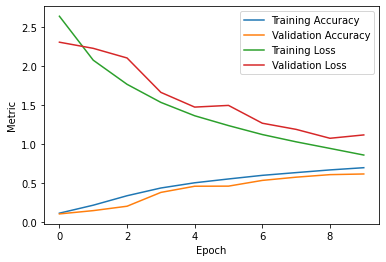

In [26]:
resnet_32_arch = ResNet(((2, 64), (3, 128), (3, 256), (3, 512)))

resnet_32_Model = Train_Model(resnet_32_arch, nn.CrossEntropyLoss(), torch.optim.SGD(resnet_32_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
resnet_32_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

resnet_32_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(resnet_32_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("ResNet-32 Model Train Accuracy:", resnet_32_Model.Metrics["Training_Accuracy"][-1].item())
print("ResNet-32 Model Test Accuracy:", resnet_32_Model.Metrics["Test_Accuracy"])

    
resnet_32_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(resnet_32_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(resnet_32_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(resnet_32_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(resnet_32_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Results --  ResNet(18,26,32 Architectures) Model Comparison
#### ResNet-18 Model

---



Time Taken to Train: 0:05:13.292934  
ResNet-18 Model Train Accuracy: 0.9243401885032654  
ResNet-18 Model Test Accuracy: 0.7236999869346619  
Macs:148.76 MMac | Params:11.18 M

#### ResNet-26 Model

---


    
Time Taken to Train: 0:05:24.531777  
ResNet-26 Model Train Accuracy: 0.8908166289329529  
ResNet-26 Model Test Accuracy: 0.7288999557495117  
Macs:186.59 MMac | Params:12.66 M

#### ResNet-32 Model

---

Time Taken to Train: 0:05:34.554755  
ResNet-32 Model Train Accuracy: 0.6978122591972351  
ResNet-32 Model Test Accuracy: 0.6252999901771545  
Macs:205.47 MMac | Params:17.38 M

Interms of model complexity, ResNet did show a great performance with respect to the amount of parameters and computational units( has lower number) when compared to VGG and GoogLeNet models.

Increasing the depth didn't really improve the models.


Problem 4) Denset Model -- Bonus Question

In [27]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [28]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            
            X = torch.cat((X, Y), dim=1)
        return X

In [29]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)

In [30]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [31]:
blk = transition_block(10)


In [32]:
class DenseNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
      super(DenseNet, self).__init__()
      self.save_hyperparameters()
      self.net = nn.Sequential(self.b1())
      for i, num_convs in enumerate(arch):
          self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                            growth_rate))
          
          num_channels += num_convs * growth_rate
          if i != len(arch) - 1:
              num_channels //= 2
              self.net.add_module(f'tran_blk{i+1}', transition_block(
                  num_channels))
      self.net.add_module('last', nn.Sequential(
          nn.LazyBatchNorm2d(), nn.ReLU(),
          nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
          nn.LazyLinear(num_classes)))
      self.net.apply(d2l.init_cnn)

    def forward(self, x):
        return self.net(x)

100%|██████████| 157/157 [00:25<00:00,  6.24it/s]

Current Epoch: 1
Training_Loss: 1.9865892480133445  | Validation_Loss: 2.3024543464183806
Training_Accuracy: 0.29404059052467346  | Validation_Accuracy: 0.11994870007038116



100%|██████████| 157/157 [00:29<00:00,  5.40it/s]

Current Epoch: 2
Training_Loss: 1.4450056917348486  | Validation_Loss: 1.6473429173231124
Training_Accuracy: 0.4703933298587799  | Validation_Accuracy: 0.3789897859096527



100%|██████████| 157/157 [00:28<00:00,  5.46it/s]

Current Epoch: 3
Training_Loss: 1.2386455748491227  | Validation_Loss: 1.4100147187709808
Training_Accuracy: 0.552726149559021  | Validation_Accuracy: 0.4878161549568176



100%|██████████| 157/157 [00:25<00:00,  6.18it/s]

Current Epoch: 4
Training_Loss: 1.0583284015108825  | Validation_Loss: 1.3527561634778977
Training_Accuracy: 0.6238508820533752  | Validation_Accuracy: 0.5264450311660767



100%|██████████| 157/157 [00:25<00:00,  6.20it/s]

Current Epoch: 5
Training_Loss: 0.9170454197628483  | Validation_Loss: 1.0866026714444161
Training_Accuracy: 0.6792738437652588  | Validation_Accuracy: 0.6215074062347412



100%|██████████| 157/157 [00:30<00:00,  5.13it/s]


Current Epoch: 6
Training_Loss: 0.7961368511436852  | Validation_Loss: 1.0073020860552788
Training_Accuracy: 0.7229923605918884  | Validation_Accuracy: 0.644310474395752


100%|██████████| 157/157 [00:28<00:00,  5.43it/s]

Current Epoch: 7
Training_Loss: 0.6833461610374937  | Validation_Loss: 1.1334822162985803
Training_Accuracy: 0.7642166018486023  | Validation_Accuracy: 0.6292586326599121



100%|██████████| 157/157 [00:28<00:00,  5.47it/s]

Current Epoch: 8
Training_Loss: 0.5790552069806749  | Validation_Loss: 0.9210527032613754
Training_Accuracy: 0.7993338704109192  | Validation_Accuracy: 0.6786718964576721



100%|██████████| 157/157 [00:29<00:00,  5.34it/s]

Current Epoch: 9
Training_Loss: 0.48103465870687157  | Validation_Loss: 0.9927668511867523
Training_Accuracy: 0.8351234197616577  | Validation_Accuracy: 0.6719495058059692



100%|██████████| 157/157 [00:25<00:00,  6.16it/s]

Current Epoch: 10
Training_Loss: 0.3866064212504466  | Validation_Loss: 0.9207560777664184
Training_Accuracy: 0.8655053377151489  | Validation_Accuracy: 0.7038558721542358


Time Taken to Train: 0:05:34.631654
DenseNet Model Train Accuracy: 0.8655053377151489
DenseNet Model Test Accuracy: 0.624500036239624
Macs:148.76 MMac | Params:11.18 M


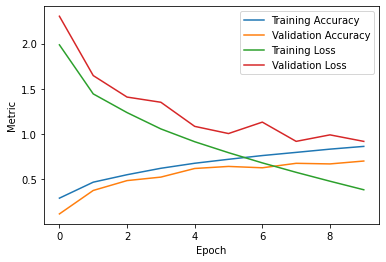

In [33]:
densenet_arch = ResNet(((2, 64), (2, 128), (2, 256), (2, 512)))

densenet_Model = Train_Model(densenet_arch, nn.CrossEntropyLoss(), torch.optim.SGD(densenet_arch.parameters(), lr=0.1, momentum=0.9), MulticlassAccuracy, "Classification",  device_to_use, 10)

t0 = datetime.now()
densenet_Model.fit(trainLoader, validateLoader, 10)
t1 = datetime.now()

densenet_Model.Test_Model(testLoader)

macs, params = get_model_complexity_info(densenet_Model.model, (3, 64, 64), as_strings=True, print_per_layer_stat=False, verbose=True)


print("Time Taken to Train:", t1 - t0)
print("DenseNet Model Train Accuracy:", densenet_Model.Metrics["Training_Accuracy"][-1].item())
print("DenseNet Model Test Accuracy:", densenet_Model.Metrics["Test_Accuracy"])

    
densenet_Model.model.to("cpu")
print(f"Macs:{macs} | Params:{params}")


### PLOTTING METRICS
plt.plot(densenet_Model.Metrics['Training_Accuracy'], label='Training Accuracy')
plt.plot(densenet_Model.Metrics['Validation_Accuracy'], label='Validation Accuracy')
plt.plot(densenet_Model.Metrics['Training_Loss'], label='Training Loss')
plt.plot(densenet_Model.Metrics['Validation_Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()

### Results
#### DenseNet Model

---



Time Taken to Train: 0:05:34.631654  
DenseNet Model Train Accuracy: 0.8655053377151489  
DenseNet Model Test Accuracy: 0.624500036239624  
Macs:148.76 MMac | Params:11.18 M

ResNet-18 Model did show a better performance with respect to the train and test accuracies when compared to the DenseNet Model. (Parameters and computational units are the same)